# Preliminary EDA for Data Understanding (Lung1)

This notebook inventories NSCLC-Radiomics (Lung1) raw data, validates CT and RTSTRUCT availability, samples key DICOM metadata, checks CT↔RTSTRUCT FrameOfReference alignment on a subset, and confirms clinical CSV joinability. 

Run this notebook after placing the NSCLC-Radiomics (Lung1) raw data in the `data/raw` folder, including both the downloaded manifest output and the clinical metadata.  

Running this notebook confirms readiness for the "Exploration" tasks in `plan.md`.

## Setup

Confirms basic files exist and creates helper functions

In [1]:
# Setup
from __future__ import annotations

from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import os
import json
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import SimpleITK as sitk

# Display opts
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)
sns.set_context("notebook")

# Paths
ROOT = Path("/Users/kai/workspace/capstone").resolve()
RAW = ROOT / "data" / "raw"
RAW_DICOM_ROOT = RAW / "NSCLC-Radiomics"
MANIFEST_CSV = RAW / "metadata.csv"
CLINICAL_CSV = RAW / "NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"

# Config
COVERAGE_THRESHOLD = 0.95
JOIN_THRESHOLD = 0.95
CT_SAMPLE_MAX_PATIENTS = 30  # bound heavy IO
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

@dataclass
class SeriesRecord:
    subject_id: str
    modality: str
    num_images: Optional[int]
    manufacturer: Optional[str]
    series_description: Optional[str]
    file_location: Path


def resolve_series_dir(file_location: str | Path) -> Path:
    # Manifest uses './NSCLC-Radiomics/...' roots; normalize to absolute
    loc = str(file_location).lstrip("./")
    full_path = RAW / loc
    return full_path


def safe_first_dcm_in_dir(series_dir: Path) -> Optional[Path]:
    if not series_dir.exists():
        return None
    # Try common DICOM patterns
    for pattern in ("*.dcm", "*.*"):
        matches = list(series_dir.glob(pattern))
        if matches:
            # Prefer actual DICOM files by quick check of magic
            for candidate in matches:
                try:
                    ds = pydicom.dcmread(str(candidate), stop_before_pixels=True)
                    if getattr(ds, "SOPClassUID", None) is not None:
                        return candidate
                except Exception:
                    continue
            return matches[0]
    # Fallback deep search
    for candidate in series_dir.rglob("*.dcm"):
        try:
            ds = pydicom.dcmread(str(candidate), stop_before_pixels=True)
            if getattr(ds, "SOPClassUID", None) is not None:
                return candidate
        except Exception:
            continue
    return None


def extract_ct_tags(ds: pydicom.dataset.FileDataset) -> Dict[str, Optional[str]]:
    def get(attr: str) -> Optional[str]:
        return getattr(ds, attr, None)
    # PixelSpacing may be list-like
    px = get("PixelSpacing")
    if isinstance(px, (list, tuple)):
        px = [float(x) for x in px]
    st = get("SliceThickness")
    try:
        st = float(st) if st is not None else None
    except Exception:
        pass
    kernel = get("ConvolutionKernel")
    if isinstance(kernel, (list, tuple)):
        kernel = "/".join(map(str, kernel))
    tags = {
        "Manufacturer": get("Manufacturer"),
        "SeriesInstanceUID": get("SeriesInstanceUID"),
        "FrameOfReferenceUID": get("FrameOfReferenceUID"),
        "PixelSpacing": px,
        "SliceThickness": st,
        "ConvolutionKernel": kernel,
    }
    return tags


def extract_rtstruct_for(ds: pydicom.dataset.FileDataset) -> Optional[str]:
    # RTSTRUCT FoR via ReferencedFrameOfReferenceSequence
    try:
        seq = ds.ReferencedFrameOfReferenceSequence
        if seq and len(seq) > 0:
            return getattr(seq[0], "FrameOfReferenceUID", None)
    except Exception:
        pass
    # Fallback attribute if present
    return getattr(ds, "FrameOfReferenceUID", None)


def choose_preferred_ct_series(ct_rows: pd.DataFrame) -> Optional[pd.Series]:
    if ct_rows.empty:
        return None
    # Prefer max Number of Images; tie-break by earliest Study Date if available
    rows = ct_rows.copy()
    def to_int(x):
        try:
            return int(x)
        except Exception:
            return -1
    rows["_num_images"] = rows["Number of Images"].apply(to_int)
    rows = rows.sort_values(["_num_images"], ascending=[False])
    return rows.iloc[0]

print("ROOT:", ROOT)
for p in (RAW, RAW_DICOM_ROOT, MANIFEST_CSV, CLINICAL_CSV):
    print("exists", str(p), p.exists())


ROOT: /Users/kai/workspace/capstone
exists /Users/kai/workspace/capstone/data/raw True
exists /Users/kai/workspace/capstone/data/raw/NSCLC-Radiomics True
exists /Users/kai/workspace/capstone/data/raw/metadata.csv True
exists /Users/kai/workspace/capstone/data/raw/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv True


### Interpretation

* This setup cell prints the project root and verifies that the expected raw data paths and CSV files exist. 
* If any value shows `False`, the dataset is incomplete or paths are misconfigured; fix paths or place the missing files before proceeding.


## Manifest/Clinical Data Availability

In [2]:
# Load manifests
manifest = pd.read_csv(MANIFEST_CSV)
clinical = pd.read_csv(CLINICAL_CSV)

# Normalize column names we rely on
required_cols = [
    "Subject ID",
    "Modality",
    "Number of Images",
    "Manufacturer",
    "Series Description",
    "File Location",
]
missing_cols = [c for c in required_cols if c not in manifest.columns]
if missing_cols:
    raise ValueError(f"Manifest missing expected columns: {missing_cols}\nHave: {list(manifest.columns)}")

print("Manifest shape:", manifest.shape)
print("Clinical shape:", clinical.shape)
print("Unique subjects in manifest:", manifest["Subject ID"].nunique())
print("Modalities counts:\n", manifest["Modality"].value_counts())

# Quick peek
display(manifest.head(3))
display(clinical.head(3))


Manifest shape: (1265, 17)
Clinical shape: (422, 10)
Unique subjects in manifest: 422
Modalities counts:
 Modality
RTSTRUCT    422
CT          422
SEG         421
Name: count, dtype: int64


,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.2.276.0.7230010.3.1.3.2323910823.20524.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,NaN,09-18-2008,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,17.89 MB,./NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID...,2025-11-08T16:47:08.997
1,1.3.6.1.4.1.32722.99.99.2279381215866080725084...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,NaN,09-18-2008,NaN,Varian Medical Systems,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.51 MB,./NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID...,2025-11-08T16:47:09.414
2,1.2.276.0.7230010.3.1.3.2323910823.11504.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,NaN,01-01-2014,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,22.22 MB,./NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID...,2025-11-08T16:47:11.4


,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1


### Interpretation

* This loads the TCIA manifest and the clinical CSV. 
* Use the printed shapes and `value_counts()` to confirm we have many rows and the expected modalities (`CT`, `RTSTRUCT`, optional `SEG`). 
* An error here (missing columns) means the manifest format is unexpected.

## Per-Subject Inventory

In [3]:
# Build per-patient inventory (CT / RTSTRUCT / SEG)
modalities = manifest[["Subject ID", "Modality", "Number of Images", "Manufacturer", "Series Description", "File Location"]].copy()
modalities["series_dir"] = modalities["File Location"].apply(resolve_series_dir)

# Partition by modality
df_ct = modalities[modalities["Modality"] == "CT"].copy()
df_rs = modalities[modalities["Modality"].str.contains("RTSTRUCT", na=False)].copy()
df_seg = modalities[modalities["Modality"] == "SEG"].copy()

subjects = sorted(modalities["Subject ID"].unique())

# Build minimal inventory per subject
from collections import defaultdict
inv = []
for sid in subjects:
    ct_rows = df_ct[df_ct["Subject ID"] == sid]
    rs_rows = df_rs[df_rs["Subject ID"] == sid]
    seg_rows = df_seg[df_seg["Subject ID"] == sid]
    inv.append({
        "Subject ID": sid,
        "has_CT": not ct_rows.empty,
        "has_RTSTRUCT": not rs_rows.empty,
        "has_SEG": not seg_rows.empty,
        "num_CT_series": int(ct_rows.shape[0]),
        "num_RS_series": int(rs_rows.shape[0]),
        "num_SEG_series": int(seg_rows.shape[0]),
    })

inventory = pd.DataFrame(inv)
display(inventory.head(10))
print("Total subjects:", len(inventory))
print("Subjects with CT:", int(inventory["has_CT"].sum()))
print("Subjects with RTSTRUCT:", int(inventory["has_RTSTRUCT"].sum()))
print("Subjects with both CT & RTSTRUCT:", int(((inventory["has_CT"]) & (inventory["has_RTSTRUCT"])) .sum()))



,Subject ID,has_CT,has_RTSTRUCT,has_SEG,num_CT_series,num_RS_series,num_SEG_series
0,LUNG1-001,True,True,True,1,1,1
1,LUNG1-002,True,True,True,1,1,1
2,LUNG1-003,True,True,True,1,1,1
3,LUNG1-004,True,True,True,1,1,1
4,LUNG1-005,True,True,True,1,1,1
5,LUNG1-006,True,True,True,1,1,1
6,LUNG1-007,True,True,True,1,1,1
7,LUNG1-008,True,True,True,1,1,1
8,LUNG1-009,True,True,True,1,1,1
9,LUNG1-010,True,True,True,1,1,1


Total subjects: 422
Subjects with CT: 422
Subjects with RTSTRUCT: 422
Subjects with both CT & RTSTRUCT: 422


### Interpretation 

* The inventory table shows, per `Subject ID`, whether CT (`has_CT`) and RTSTRUCT (`has_RTSTRUCT`) are present and how many series exist. 
* We expect most patients to have both; any `False` flags indicate gaps to investigate.

## Coverage Requirements

In [4]:
# Coverage metrics and assertions (CT + RTSTRUCT)
num_subjects = len(inventory)
num_ct = int(inventory["has_CT"].sum())
num_rs = int(inventory["has_RTSTRUCT"].sum())
num_both = int(((inventory["has_CT"]) & (inventory["has_RTSTRUCT"])) .sum())

coverage_ct = num_ct / num_subjects if num_subjects else 0.0
coverage_rs = num_rs / num_subjects if num_subjects else 0.0
coverage_both = num_both / num_subjects if num_subjects else 0.0

print({
    "num_subjects": num_subjects,
    "coverage_ct": round(coverage_ct, 3),
    "coverage_rtstruct": round(coverage_rs, 3),
    "coverage_ct_and_rtstruct": round(coverage_both, 3),
})

missing_ct = inventory.loc[~inventory["has_CT"], "Subject ID"].tolist()
missing_rs = inventory.loc[~inventory["has_RTSTRUCT"], "Subject ID"].tolist()

print("Missing CT (first 10):", missing_ct[:10])
print("Missing RTSTRUCT (first 10):", missing_rs[:10])

assert coverage_ct >= COVERAGE_THRESHOLD, f"CT coverage {coverage_ct:.2%} < threshold {COVERAGE_THRESHOLD:.0%}"
assert coverage_rs >= COVERAGE_THRESHOLD, f"RTSTRUCT coverage {coverage_rs:.2%} < threshold {COVERAGE_THRESHOLD:.0%}"
assert coverage_both >= COVERAGE_THRESHOLD, f"CT+RTSTRUCT coverage {coverage_both:.2%} < threshold {COVERAGE_THRESHOLD:.0%}"


{'num_subjects': 422, 'coverage_ct': 1.0, 'coverage_rtstruct': 1.0, 'coverage_ct_and_rtstruct': 1.0}
Missing CT (first 10): []
Missing RTSTRUCT (first 10): []


### Interpretation

* These coverage metrics quantify how much of the cohort has CT, RTSTRUCT, and both. 
* The assertions enforce minimum coverage thresholds. 
* If an assertion fails, examine the printed missing `Subject ID`s and fix the dataset before continuing.

## Clinical Data Coverage

In [5]:
# Clinical CSV join validation
# Manifest subjects
subjects_manifest = set(inventory["Subject ID"].unique())

# Clinical subjects
if "PatientID" not in clinical.columns:
    raise ValueError("Clinical CSV missing 'PatientID' column")
subjects_clinical = set(clinical["PatientID"].dropna().astype(str).unique())

# Normalize to same ID format (already looks like LUNG1-xxx)
joinable = subjects_manifest & subjects_clinical
join_rate = len(joinable) / len(subjects_manifest) if subjects_manifest else 0.0

print({
    "subjects_manifest": len(subjects_manifest),
    "subjects_clinical": len(subjects_clinical),
    "joinable_subjects": len(joinable),
    "join_rate": round(join_rate, 3),
})

# Show first few missing in clinical
missing_in_clinical = sorted(subjects_manifest - subjects_clinical)
print("Missing in clinical (first 10):", missing_in_clinical[:10])

assert join_rate >= JOIN_THRESHOLD, f"Clinical join rate {join_rate:.2%} < threshold {JOIN_THRESHOLD:.0%}"


{'subjects_manifest': 422, 'subjects_clinical': 422, 'joinable_subjects': 422, 'join_rate': 1.0}
Missing in clinical (first 10): []


### Interpretation

* This checks whether clinical records can be joined to imaging subjects. 
* A high `join_rate` means the clinical CSV covers most imaged patients. 
* If the assertion fails, inspect the first missing IDs to identify naming mismatches or missing clinical rows.

## CT Metadata Analysis

Sampling 30 patients for CT metadata...


,Subject ID,SeriesDir,NumImages,Manufacturer,SeriesInstanceUID,FrameOfReferenceUID,PixelSpacing,SliceThickness,ConvolutionKernel
0,LUNG1-403,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.3164445486800054133943...,1.3.6.1.4.1.32722.99.99.3801097939454252422790...,"[0.9765625, 0.9765625]",3.0,B19f
1,LUNG1-012,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,109,"CMS, Inc.",1.3.6.1.4.1.32722.99.99.6548856915427024669919...,1.3.6.1.4.1.32722.99.99.1659251140356443807262...,"[0.9770, 0.9770]",3.0,None
2,LUNG1-348,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,132,SIEMENS,1.3.6.1.4.1.32722.99.99.3104809005727477840573...,1.3.6.1.4.1.32722.99.99.9791701525950172153504...,"[0.9765625, 0.9765625]",3.0,B19f
3,LUNG1-320,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,131,SIEMENS,1.3.6.1.4.1.32722.99.99.2713400057815152127817...,1.3.6.1.4.1.32722.99.99.2662246114654223188655...,"[0.9765625, 0.9765625]",3.0,B19f
4,LUNG1-248,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.3352525197469145845328...,1.3.6.1.4.1.32722.99.99.6743100925919512219745...,"[0.9765625, 0.9765625]",3.0,B41f
5,LUNG1-359,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.3058931863409965859597...,1.3.6.1.4.1.32722.99.99.1472827184333922902365...,"[0.9765625, 0.9765625]",3.0,B19f
6,LUNG1-044,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,99,"CMS, Inc.",1.3.6.1.4.1.32722.99.99.1507877282536873804588...,1.3.6.1.4.1.32722.99.99.2829649433307944513909...,"[0.9770, 0.9770]",3.0,None
7,LUNG1-003,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,107,"CMS, Inc.",1.3.6.1.4.1.32722.99.99.2389222799296192439904...,1.3.6.1.4.1.32722.99.99.2067784634305097085472...,"[0.9770, 0.9770]",3.0,None
8,LUNG1-216,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.2143675881885239241247...,1.3.6.1.4.1.32722.99.99.2117839321906678219041...,"[0.9765625, 0.9765625]",3.0,B30f
9,LUNG1-086,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,176,SIEMENS,1.3.6.1.4.1.32722.99.99.1637313385502800652839...,1.3.6.1.4.1.32722.99.99.7735060697620594441170...,"[0.9765625, 0.9765625]",3.0,B31f


Vendors:
Manufacturer
SIEMENS      25
CMS, Inc.     5
Name: count, dtype: int64
Kernels:
ConvolutionKernel
B19f    8
B30f    8
None    5
B41f    3
B31f    3
B18f    2
B31s    1
Name: count, dtype: int64


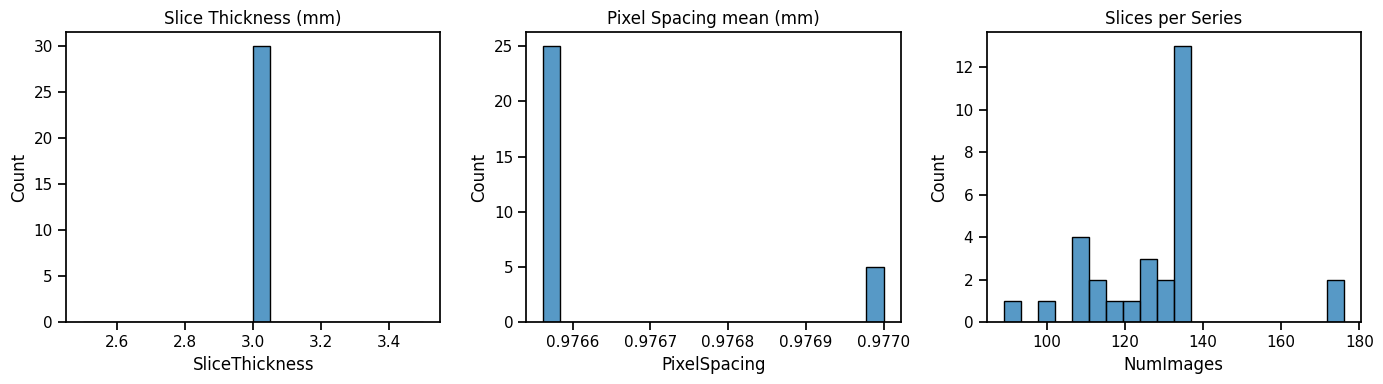

In [6]:
# Sample CT metadata for up to N patients and compute distributions
eligible = inventory[(inventory["has_CT"]) & (inventory["has_RTSTRUCT"])]["Subject ID"].tolist()
random.shuffle(eligible)
sample_subjects = eligible[:CT_SAMPLE_MAX_PATIENTS]
print(f"Sampling {len(sample_subjects)} patients for CT metadata...")

rows = []
for sid in sample_subjects:
    ct_rows = df_ct[df_ct["Subject ID"] == sid]
    chosen = choose_preferred_ct_series(ct_rows)
    if chosen is None:
        continue
    series_dir = chosen["series_dir"]
    dcm_file = safe_first_dcm_in_dir(series_dir)
    if dcm_file is None:
        continue
    try:
        ds = pydicom.dcmread(str(dcm_file), stop_before_pixels=True)
        tags = extract_ct_tags(ds)
        num_images = int(chosen.get("Number of Images", -1)) if pd.notna(chosen.get("Number of Images", None)) else -1
        rows.append({
            "Subject ID": sid,
            "SeriesDir": str(series_dir),
            "NumImages": num_images,
            **tags,
        })
    except Exception as e:
        print(f"WARN: {sid} failed to read CT DICOM: {e}")

ct_sample_df = pd.DataFrame(rows)
display(ct_sample_df.head(10))

# Distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
if not ct_sample_df.empty:
    # Slice thickness
    sns.histplot(ct_sample_df["SliceThickness"].dropna().astype(float), bins=20, ax=axes[0])
    axes[0].set_title("Slice Thickness (mm)")
    # Pixel spacing (mean of in-plane if present)
    def mean_px(x):
        try:
            return float(np.mean(x))
        except Exception:
            return np.nan
    px_mean = ct_sample_df["PixelSpacing"].apply(mean_px)
    sns.histplot(px_mean.dropna(), bins=20, ax=axes[1])
    axes[1].set_title("Pixel Spacing mean (mm)")
    # Num images (slices)
    sns.histplot(ct_sample_df["NumImages"].replace(-1, np.nan).dropna(), bins=20, ax=axes[2])
    axes[2].set_title("Slices per Series")
    plt.tight_layout()
else:
    plt.close(fig)
    print("No CT samples read.")

print("Vendors:")
print(ct_sample_df["Manufacturer"].value_counts(dropna=False))
print("Kernels:")
print(ct_sample_df["ConvolutionKernel"].value_counts(dropna=False).head(15))


### Interpretation

These plots summarize CT acquisition characteristics. 
- Slice Thickness: distribution in millimeters; thicker slices can blur boundaries.
- Pixel Spacing mean: in-plane resolution; smaller is higher detail.
- Slices per Series: proxy for z-coverage/resolution.

Vendor and kernel counts reveal potential scanner/recon biases.

## Frame of Reference Alignment Check (CT vs RTSTRUCT)

In [7]:
# Alignment check: FrameOfReferenceUID CT vs RTSTRUCT (sampled subjects)
if ct_sample_df.empty:
    print("No CT samples to align.")
else:
    results = []
    for sid in ct_sample_df["Subject ID"].unique():
        # CT slice FoR
        ct_row = ct_sample_df[ct_sample_df["Subject ID"] == sid].iloc[0]
        ct_dcm_candidate = safe_first_dcm_in_dir(Path(ct_row["SeriesDir"]))
        if ct_dcm_candidate is None:
            results.append({"Subject ID": sid, "match": False, "reason": "no_ct_dcm"})
            continue
        try:
            ds_ct = pydicom.dcmread(str(ct_dcm_candidate), stop_before_pixels=True)
            ct_for = getattr(ds_ct, "FrameOfReferenceUID", None)
        except Exception as e:
            results.append({"Subject ID": sid, "match": False, "reason": f"ct_read_err:{e}"})
            continue

        # Choose an RTSTRUCT series
        rs_rows = df_rs[df_rs["Subject ID"] == sid]
        if rs_rows.empty:
            results.append({"Subject ID": sid, "match": False, "reason": "no_rtstruct"})
            continue
        rs_series_dir = rs_rows.iloc[0]["series_dir"]
        rs_dcm = safe_first_dcm_in_dir(rs_series_dir)
        if rs_dcm is None:
            results.append({"Subject ID": sid, "match": False, "reason": "no_rs_dcm"})
            continue
        try:
            ds_rs = pydicom.dcmread(str(rs_dcm), stop_before_pixels=True)
            rs_for = extract_rtstruct_for(ds_rs)
        except Exception as e:
            results.append({"Subject ID": sid, "match": False, "reason": f"rs_read_err:{e}"})
            continue

        match = (ct_for is not None) and (rs_for is not None) and (str(ct_for) == str(rs_for))
        results.append({"Subject ID": sid, "match": bool(match), "ct_for": ct_for, "rs_for": rs_for})

    align_df = pd.DataFrame(results)
    display(align_df.head(10))
    n_match = int(align_df["match"].sum())
    n_total = align_df.shape[0]
    print(f"Alignment matches: {n_match}/{n_total} ({(n_match/n_total if n_total else 0):.1%})")
    assert n_match == n_total, "FoR mismatch detected in sampled subjects"


,Subject ID,match,ct_for,rs_for
0,LUNG1-403,True,1.3.6.1.4.1.32722.99.99.3801097939454252422790...,1.3.6.1.4.1.32722.99.99.3801097939454252422790...
1,LUNG1-012,True,1.3.6.1.4.1.32722.99.99.1659251140356443807262...,1.3.6.1.4.1.32722.99.99.1659251140356443807262...
2,LUNG1-348,True,1.3.6.1.4.1.32722.99.99.9791701525950172153504...,1.3.6.1.4.1.32722.99.99.9791701525950172153504...
3,LUNG1-320,True,1.3.6.1.4.1.32722.99.99.2662246114654223188655...,1.3.6.1.4.1.32722.99.99.2662246114654223188655...
4,LUNG1-248,True,1.3.6.1.4.1.32722.99.99.6743100925919512219745...,1.3.6.1.4.1.32722.99.99.6743100925919512219745...
5,LUNG1-359,True,1.3.6.1.4.1.32722.99.99.1472827184333922902365...,1.3.6.1.4.1.32722.99.99.1472827184333922902365...
6,LUNG1-044,True,1.3.6.1.4.1.32722.99.99.2829649433307944513909...,1.3.6.1.4.1.32722.99.99.2829649433307944513909...
7,LUNG1-003,True,1.3.6.1.4.1.32722.99.99.2067784634305097085472...,1.3.6.1.4.1.32722.99.99.2067784634305097085472...
8,LUNG1-216,True,1.3.6.1.4.1.32722.99.99.2117839321906678219041...,1.3.6.1.4.1.32722.99.99.2117839321906678219041...
9,LUNG1-086,True,1.3.6.1.4.1.32722.99.99.7735060697620594441170...,1.3.6.1.4.1.32722.99.99.7735060697620594441170...


Alignment matches: 30/30 (100.0%)


### Interpretation

* The alignment table compares `FrameOfReferenceUID` between a sampled CT slice and its RTSTRUCT. 
* 100% matches indicate contours are defined in the same reference frame as the CT; any mismatch requires investigating RTSTRUCT selection or study linkage.

## Summary & Gate

- This notebook inventoried DICOM series and computed coverage for CT and RTSTRUCT.
- It validated clinical CSV joinability and sampled CT metadata distributions.
- It checked CT↔RTSTRUCT FrameOfReferenceUID alignment on a representative subset.

If any assertion failed above, the dataset needs attention before proceeding to Data Preparation.